# STAC to GeoCroissant Time-Series Converter

<img src="../asset/GeoCroissant.jpg" alt="GeoCroissant" width="150" style="float: right; margin-left: 50px;">

Converts STAC items from Microsoft Planetary Computer to GeoCroissant format with proper time-series support.

## Workflow

1. Install dependencies
2. Define data fetching functions 
3. Define GeoCroissant conversion functions 
4. Generate GeoCroissant JSON with fresh URLs 
5. Validate the GeoCroissant JSON 
6. Visualize RGB composite from GeoCroissant metadata 

## Step 1: Install Dependencies

Install required Python packages:
- `pystac-client`: For searching and accessing STAC catalogs
- `planetary-computer`: For signing Microsoft Planetary Computer URLs

In [1]:
!pip install -q pystac-client planetary-computer

## Step 2: Define Data Fetching Function

Define a function to fetch STAC items from Microsoft Planetary Computer. This function:
- Searches for satellite imagery based on collection ID, bounding box, and time range
- Groups items by month and selects one representative item per month
- Returns a time-series of monthly observations

In [2]:
import pystac_client
import planetary_computer
from collections import defaultdict
from datetime import datetime
import json
import sys


def fetch_monthly_items(collection, bbox, time_range):
    """Fetch one STAC item per month for a given spatial and temporal extent.
    
    Args:
        collection: STAC collection ID
        bbox: Bounding box [min_lon, min_lat, max_lon, max_lat]
        time_range: Date range in format "YYYY-MM-DD/YYYY-MM-DD"
        
    Returns:
        List of STAC items (one per month)
    """
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )
    
    search = catalog.search(
        collections=[collection],
        bbox=bbox,
        datetime=time_range,
    )
    
    items = list(search.get_items())
    
    # Group by month
    monthly_items = defaultdict(list)
    for item in items:
        item_date = datetime.fromisoformat(item.datetime.isoformat())
        year_month = item_date.strftime("%Y-%m")
        monthly_items[year_month].append(item)
    
    # Select first item from each month
    selected_items = []
    for month in sorted(monthly_items.keys()):
        if monthly_items[month]:
            selected_items.append(monthly_items[month][0])
    
    return selected_items

## Step 3: Define GeoCroissant Conversion Functions

Define functions to convert STAC items to GeoCroissant format:

In [3]:
def convert_items_to_geocroissant(items_list):
    """Convert list of STAC items to Geocroissant Dataset format with proper structure.
    
    Key principles:
    - Band configuration and spectral metadata defined ONCE at dataset level
    - Distribution contains FileSet entries for monthly spectral band TIFFs
    - RecordSet examples show only 2 sample records (not all data!)
    - geocr:timeSeriesIndex indicates temporal ordering
    
    Args:
        items_list: List of STAC item dictionaries with full metadata.
        
    Returns:
        Dictionary with Geocroissant structure conforming to croissant.ttl and geocr.ttl.
    """
    
    if not items_list:
        return {}
    
    # Calculate temporal and spatial extents
    min_date = None
    max_date = None
    min_lon = float('inf')
    min_lat = float('inf')
    max_lon = float('-inf')
    max_lat = float('-inf')
    
    for item in items_list:
        dt_str = item.get('properties', {}).get('datetime')
        if dt_str:
            dt = datetime.fromisoformat(dt_str.replace('Z', '+00:00'))
            if min_date is None or dt < min_date:
                min_date = dt
            if max_date is None or dt > max_date:
                max_date = dt
        
        bbox = item.get('bbox', [])
        if bbox and len(bbox) >= 4:
            min_lon = min(min_lon, bbox[0])
            min_lat = min(min_lat, bbox[1])
            max_lon = max(max_lon, bbox[2])
            max_lat = max(max_lat, bbox[3])
    
    # Extract spectral bands from first item - DEFINED ONCE for entire dataset
    first_item = items_list[0]
    spectral_bands = []
    band_names = []
    
    for asset_key, asset in first_item.get('assets', {}).items():
        if 'B' in asset_key or 'B8A' in asset_key:
            band_names.append(asset_key)
            eo_bands = asset.get('eo:bands', [])
            if eo_bands:
                spectral_band_entry = {
                    "@type": "geocr:SpectralBand",
                    "name": eo_bands[0].get('common_name', asset_key),
                    "geocr:centerWavelength": {
                        "@type": "QuantitativeValue",
                        "value": eo_bands[0].get('center_wavelength'),
                        "unitText": "nm"
                    }
                }
                if eo_bands[0].get('full_width_half_max'):
                    spectral_band_entry["geocr:bandwidth"] = {
                        "@type": "QuantitativeValue",
                        "value": eo_bands[0].get('full_width_half_max'),
                        "unitText": "nm"
                    }
                spectral_bands.append(spectral_band_entry)
    
    first_props = first_item.get('properties', {})
    proj_code = first_props.get('proj:code', 'EPSG:4326')
    
    # Build Geocroissant structure
    geocr_dataset = {
        "@context": {
            "@language": "en",
            "@vocab": "https://schema.org/",
            "cr": "http://mlcommons.org/croissant/",
            "geocr": "http://mlcommons.org/croissant/geo/",
            "dct": "http://purl.org/dc/terms/",
            "sc": "https://schema.org/",
            "citeAs": "cr:citeAs",
            "column": "cr:column",
            "conformsTo": "dct:conformsTo",
            "data": {"@id": "cr:data", "@type": "@json"},
            "examples": {"@id": "cr:examples", "@type": "@json"},
            "dataBiases": "cr:dataBiases",
            "dataCollection": "cr:dataCollection",
            "dataType": {"@id": "cr:dataType", "@type": "@vocab"},
            "extract": "cr:extract",
            "field": "cr:field",
            "fileObject": "cr:fileObject",
            "fileProperty": "cr:fileProperty",
            "fileSet": "cr:fileSet",
            "format": "cr:format",
            "includes": "cr:includes",
            "isLiveDataset": "cr:isLiveDataset",
            "jsonPath": "cr:jsonPath",
            "key": "cr:key",
            "md5": "cr:md5",
            "parentField": "cr:parentField",
            "path": "cr:path",
            "personalSensitiveInformation": "cr:personalSensitiveInformation",
            "recordSet": "cr:recordSet",
            "references": "cr:references",
            "regex": "cr:regex",
            "repeated": "cr:repeated",
            "replace": "cr:replace",
            "samplingRate": "cr:samplingRate",
            "separator": "cr:separator",
            "source": "cr:source",
            "subField": "cr:subField",
            "transform": "cr:transform",
            "equivalentProperty": "cr:equivalentProperty",
            "rai": "http://mlcommons.org/croissant/RAI/"
        },
        "@type": "sc:Dataset",
        "name": "HLS_Sentinel2_TimeSeries_Jan_Dec_2025",
        "description": f"Sentinel-2B HLS time series with {len(items_list)} monthly observations. IMPORTANT: Band configuration ({len(band_names)} bands) and spectral metadata are defined ONCE at dataset level and inherited by ALL monthly observations. Individual monthly granules with their TIFF file URLs listed in distribution.",
        "conformsTo": "http://mlcommons.org/croissant/1.0",
        "version": "1.0.0",
        "alternateName": "HLS Sentinel-2 Monthly Time Series",
        "creator": {
            "@type": "Organization",
            "name": "Microsoft Planetary Computer",
            "url": "https://planetarycomputer.microsoft.com"
        },
        "keywords": [
            "satellite imagery",
            "Sentinel-2",
            "HLS",
            "multispectral",
            "time series",
            "earth observation",
            "remote sensing"
        ],
        "cr:citeAs": "Microsoft Planetary Computer HLS Sentinel-2B Collection",
        "datePublished": min_date.isoformat() if min_date else datetime.utcnow().isoformat(),
        "license": "https://creativecommons.org/licenses/by/4.0/",
        
        "spatialCoverage": {
            "@type": "Place",
            "geo": {
                "@type": "GeoShape",
                "box": f"{min_lat} {min_lon} {max_lat} {max_lon}"
            }
        },
        "temporalCoverage": f"{min_date.isoformat()}/{max_date.isoformat()}" if min_date and max_date else None,
        
        # GeoCroissant properties - DEFINED ONCE
        "geocr:spatialResolution": {
            "@type": "QuantitativeValue",
            "value": 30.0,
            "unitText": "m"
        },
        "geocr:coordinateReferenceSystem": proj_code,
        "geocr:temporalResolution": {
            "@type": "QuantitativeValue",
            "value": 1,
            "unitText": "month"
        },
        
        # Band configuration - DEFINED ONCE, applies to ALL monthly observations
        "geocr:bandConfiguration": {
            "@type": "geocr:BandConfiguration",
            "geocr:totalBands": len(band_names),
            "geocr:bandNameList": band_names
        },
        
        # Spectral metadata - DEFINED ONCE, applies to ALL monthly observations
        "geocr:spectralBandMetadata": spectral_bands,
        
        # Distribution: FileSet for each monthly granule
        "distribution": []
    }
    
    # Create FileSet entries for each month's spectral bands  
    for idx, item in enumerate(items_list, 1):
        item_id = item.get('id', f'item_{idx}')
        dt_str = item.get('properties', {}).get('datetime', '')
        
        # Get first band asset URL to extract base path
        assets = item.get('assets', {})
        if band_names and band_names[0] in assets:
            first_band_url = assets[band_names[0]].get('href', '')
            # Extract base URL (remove band-specific part)
            # URL format: https://.../HLS.S30.T11SMT.2025027T183539.v2.0/HLS.S30.T11SMT.2025027T183539.v2.0.B01.tif
            if '.B' in first_band_url:
                base_url = first_band_url.rsplit('.B', 1)[0]  # Get path without .BXX.tif
            else:
                base_url = first_band_url.rsplit('/', 1)[0]  # Get directory
        else:
            base_url = ""
        
        # Create FileSet with pattern matching for all band TIFFs
        file_set = {
            "@type": "cr:FileSet",
            "@id": f"granule_{idx}_bands",
            "name": f"{item_id}_spectral_bands",
            "description": f"13 spectral band GeoTIFF files for {item_id} ({dt_str})",
            "contentUrl": base_url,
            "encodingFormat": "image/tiff",
            "includes": "*.tif"
        }
        geocr_dataset['distribution'].append(file_set)
    
    # RecordSet with geocr:timeSeriesIndex
    time_series_recordset = {
        "@type": "cr:RecordSet",
        "@id": "time_series_observations",
        "name": "time_series_observations",
        "description": f"Time-series with {len(items_list)} monthly observations. Each record has 13 spectral bands as defined in dataset-level geocr:bandConfiguration.",
        
        # KEY for time-series: indicates temporal ordering field
        "geocr:timeSeriesIndex": "observation_datetime",
        
        "field": [
            {
                "@type": "cr:Field",
                "@id": "time_series_observations/granule_id",
                "name": "granule_id",
                "description": "Unique identifier for monthly observation",
                "dataType": "sc:Text",
                "source": {
                    "fileSet": "granule_1_bands",  # Reference first granule as example
                    "extract": {
                        "column": "granule_id"
                    }
                }
            },
            {
                "@type": "cr:Field",
                "@id": "time_series_observations/observation_datetime",
                "name": "observation_datetime",
                "description": "Observation timestamp (ISO 8601)",
                "dataType": "sc:DateTime",
                "source": {
                    "fileSet": "granule_1_bands",
                    "extract": {
                        "column": "observation_datetime"
                    }
                }
            },
            {
                "@type": "cr:Field",
                "@id": "time_series_observations/month",
                "name": "month",
                "description": "Year-month (YYYY-MM)",
                "dataType": "sc:Text",
                "source": {
                    "fileSet": "granule_1_bands",
                    "extract": {
                        "column": "month"
                    }
                }
            },
            {
                "@type": "cr:Field",
                "@id": "time_series_observations/platform",
                "name": "platform",
                "description": "Satellite platform",
                "dataType": "sc:Text",
                "source": {
                    "fileSet": "granule_1_bands",
                    "extract": {
                        "column": "platform"
                    }
                }
            },
            {
                "@type": "cr:Field",
                "@id": "time_series_observations/cloud_cover",
                "name": "cloud_cover",
                "description": "Cloud cover percentage",
                "dataType": "sc:Float",
                "source": {
                    "fileSet": "granule_1_bands",
                    "extract": {
                        "column": "cloud_cover"
                    }
                }
            }
        ],
        
        # Examples: Only 2 sample records to illustrate structure
        "examples": []
    }
    
    # Add only 2 example records (NOT all months!)
    for idx, item in enumerate(items_list[:2], 1):
        item_props = item.get('properties', {})
        item_id = item.get('id', f'item_{idx}')
        dt_str = item_props.get('datetime', '')
        dt_obj = datetime.fromisoformat(dt_str.replace('Z', '+00:00'))
        
        example = {
            "granule_id": item_id,
            "observation_datetime": dt_str,
            "month": dt_obj.strftime("%Y-%m"),
            "platform": item_props.get('platform', 'sentinel-2b'),
            "cloud_cover": item_props.get('eo:cloud_cover', 0)
        }
        time_series_recordset['examples'].append(example)
    
    geocr_dataset['recordSet'] = [time_series_recordset]
    
    return geocr_dataset

def save_geocroissant(dataset, filename):
    """Save GeoCroissant dataset to JSON file.
    
    Args:
        dataset: GeoCroissant dataset dictionary
        filename: Output file path
    """
    with open(filename, 'w') as f:
        json.dump(dataset, f, indent=2)

## Step 4: Generate GeoCroissant JSON

Fetch STAC items for the specified area and time range, then convert to GeoCroissant format:
- Collection: HLS Sentinel-2 (`hls2-s30`)
- Location: Orange County, California area
- Time range: January - December 2025

In [4]:
# Run this cell to generate GeoCroissant JSON with fresh URLs
collection = "hls2-s30"
bbox = [-117.8, 33.65, -117.65, 33.8]
time_range = "2025-01-01/2025-12-31"
output_file = "geocr-timeseries.json"

selected_items = fetch_monthly_items(collection, bbox, time_range)
items_as_dicts = [item.to_dict() for item in selected_items]
geocr_dataset = convert_items_to_geocroissant(items_as_dicts)
save_geocroissant(geocr_dataset, output_file)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pystac_client/item_search.py:925: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


## Step 5: Validate GeoCroissant JSON

Validate the generated GeoCroissant JSON file using the MLCroissant validator to ensure it conforms to the Croissant schema.

In [5]:
!mlcroissant validate --jsonld=geocr-timeseries.json

I0216 20:47:44.756744 131376160249344 validate.py:53] Done.


## Step 6: Visualize Time Series from GeoCroissant

Load the GeoCroissant JSON and visualize all monthly observations:
- Reads the GeoCroissant metadata to get URLs for each month's data
- Constructs RGB composites from bands B04 (red), B03 (green), B02 (blue)
- Displays all months in a grid layout showing temporal changes

This demonstrates how GeoCroissant metadata enables direct data access and visualization.

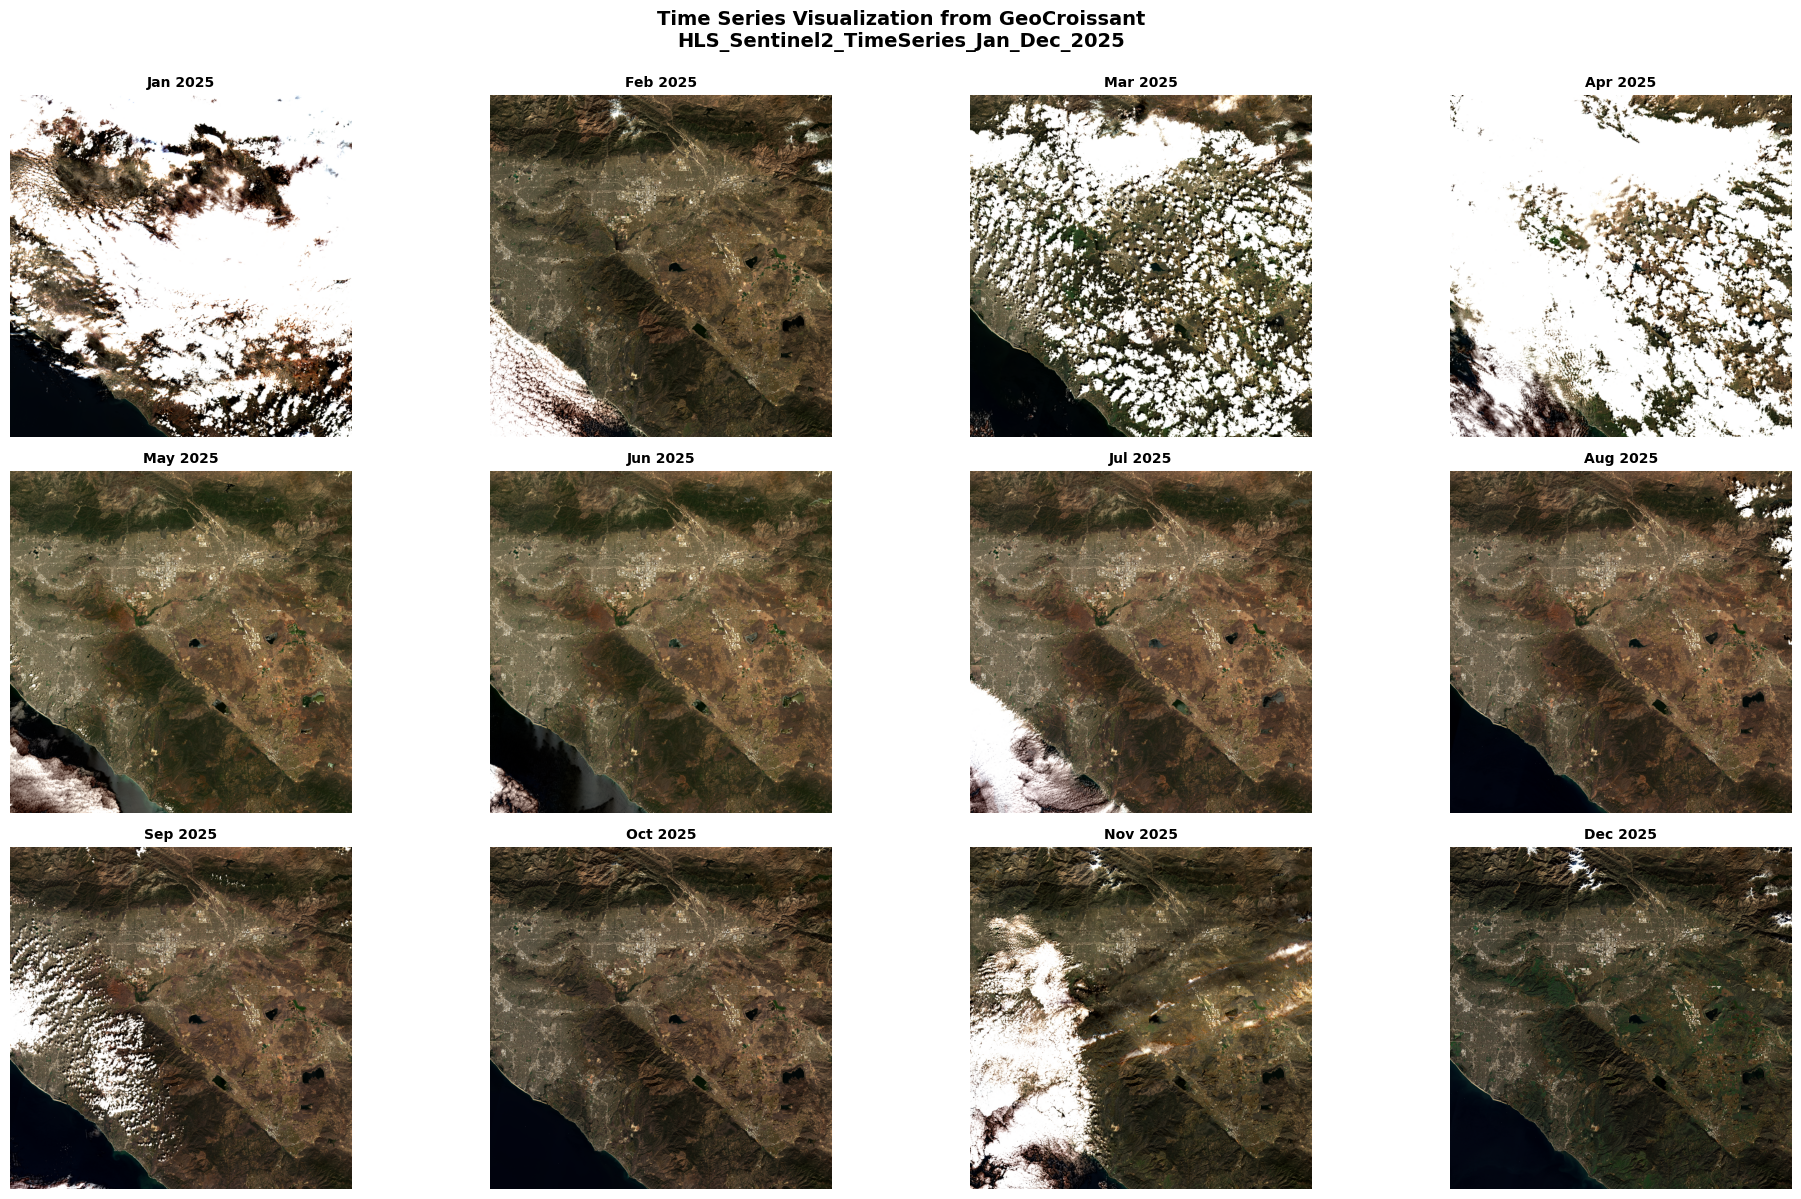

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import json
import planetary_computer
from datetime import datetime

# Load GeoCroissant JSON
with open('geocr-timeseries.json', 'r') as f:
    geocr_data = json.load(f)

# Get all FileSets from distribution (all monthly observations)
all_filesets = geocr_data['distribution']
num_months = len(all_filesets)

# Calculate grid layout (e.g., 3 or 4 columns)
cols = 4 if num_months > 6 else 3
rows = (num_months + cols - 1) // cols

# Create figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten() if num_months > 1 else [axes]

# Process each monthly granule
for idx, fileset in enumerate(all_filesets):
    base_url = fileset['contentUrl']
    granule_name = fileset['name']
    
    # Extract date from granule name or description
    granule_desc = fileset.get('description', '')
    
    # Construct URLs for RGB bands (B04=red, B03=green, B02=blue)
    red_url = f"{base_url}.B04.tif"
    green_url = f"{base_url}.B03.tif"
    blue_url = f"{base_url}.B02.tif"
    
    # Sign URLs with Planetary Computer
    red_url_signed = planetary_computer.sign(red_url)
    green_url_signed = planetary_computer.sign(green_url)
    blue_url_signed = planetary_computer.sign(blue_url)
    
    try:
        # Read RGB bands
        with rasterio.open(red_url_signed) as src:
            red = src.read(1)
        
        with rasterio.open(green_url_signed) as src:
            green = src.read(1)
        
        with rasterio.open(blue_url_signed) as src:
            blue = src.read(1)
        
        # Stack and normalize
        rgb = np.dstack((red, green, blue))
        rgb = np.clip(rgb / 3000.0, 0, 1)
        
        # Display in subplot
        axes[idx].imshow(rgb)
        
        # Extract month from description (format: "...for ITEM_ID (YYYY-MM-DDTHH:MM:SS...)")
        if '(' in granule_desc and ')' in granule_desc:
            date_str = granule_desc.split('(')[1].split(')')[0]
            try:
                date_obj = datetime.fromisoformat(date_str.replace('Z', '+00:00'))
                month_label = date_obj.strftime("%b %Y")
            except:
                month_label = f"Month {idx+1}"
        else:
            month_label = f"Month {idx+1}"
        
        axes[idx].set_title(month_label, fontsize=10, fontweight='bold')
        axes[idx].axis('off')
        
    except Exception as e:
        axes[idx].text(0.5, 0.5, f'Error loading\n{month_label}', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].axis('off')

# Hide extra subplots if grid is larger than number of months
for idx in range(num_months, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'Time Series Visualization from GeoCroissant\n{geocr_data["name"]}', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()